# Tarea 4 - Redes Neuronales

### Grupo 36:
     - N. Farías
     - J. M. Varela

## 1. Objetivo
El objetivo de esta tarea es construir un clasificador para el conjunto de datos Fashion-MNIST, utilizando redes neuronales. Particularmente se utilizarán las redes de tipo feedforward (FF) y la biblioteca PyTorch.

Se utilizarán distintas medidas como accuracy, precision, recall y F1 para evaluar el éxito del aprendizaje, así como también la matriz de confusión.


Importamos las bibliotecas necesarias y configuramos el uso de GPU si está disponible.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cuda device


## 2. Diseño

### 2.1 Conjunto de datos

Se utilizará el dataset Fashion-MNIST que contiene 60000 y 10000 imágenes de entrenamiento y test respectivamente, asociadas a 10 posibles categorías de vestimenta. Las imágenes están formadas por 28x28 pixeles en escala de gris.

A continuación se descargan los juegos de datos y se separa parte de los datos de entrenamiento para validación.

In [ ]:
all_train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

torch.manual_seed(1234)

validation_size = int(0.2 * len(all_train_data))
training_size = len(all_train_data) - validation_size
train_data, validation_data = random_split(all_train_data, [training_size, validation_size])

len(train_data), len(validation_data), len(test_data)

100%|██████████| 26421880/26421880 [00:03<00:00, 7963592.78it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139815.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2645816.61it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5020292.26it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(48000, 12000, 10000)

Se definen los DataLoaders para utilizar en el entrenamiento y validación.

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
train_dataloader_mini_batch = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_dataloader_batch = DataLoader(train_data, batch_size=len(train_data), shuffle=False)
validation_dataloader_batch = DataLoader(validation_data, batch_size=len(validation_data), shuffle=False)

### 2.2 Entrenamiento

Se definen a continuación las funciones necesarias para entrenar y evaluar las distintas redes neuronales que se probarán.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  # Set the model to training mode - important for batch normalization and dropout layers
  model.train()

  train_loss = 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return train_loss


def test_loop(dataloader, model):
  # Set the model to evaluation mode - important for batch normalization and dropout layers
  model.eval()

  size = len(dataloader.dataset)
  accuracy = 0

  # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
  # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      accuracy += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

  accuracy /= size
  return accuracy


def epoch_loop(epochs, train_dataloader, train_dataloader_acc, validation_dataloader_acc, model, loss_fn, optimizer):
  loss_epoch, train_acc_epoch, validation_acc_epoch = [], [], []

  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    loss_epoch.append(train_loss)
    print(f"{train_loss=}")

    train_accuracy = test_loop(train_dataloader_acc, model)
    train_acc_epoch.append(train_accuracy)
    print(f"{train_accuracy=}")

    validation_accuracy = test_loop(validation_dataloader_acc, model)
    validation_acc_epoch.append(validation_accuracy)
    print(f"{validation_accuracy=}\n")

  return (loss_epoch, train_acc_epoch, validation_acc_epoch)


### 2.3 Red Neuronal inicial

En primera instancia se probará una red neuronal FF sencilla con una capa oculta de 32 unidades y la función sigmoide como activación. Esta red dará como resultado para una imagen de entrada, 10 valores correspondientes a los scores para cada clase.  
Para pasar estos scores a una distribución de probabilidad basta con aplicarles la función softmax, esto no se incorporó directamente en la red neuronal ya que la función de pérdida utilizada aplica esta función automáticamente.  

Esta red se entrenó minimizando la función de entropía cruzada, utilizando descenso por gradiente estocástico con tasa de aprendizaje 0.01, durante 10 épocas.

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 32),
    nn.Sigmoid(),
    nn.Linear(32, 10)
).to(device)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
epochs = 10
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_epoch, train_acc_epoch, validation_acc_epoch = epoch_loop(epochs, train_dataloader, train_dataloader_batch, validation_dataloader_batch, model, loss_fn, optimizer)


Epoch 1
-------------------------------
train_loss=29718.972795040696
train_accuracy=0.842625
validation_accuracy=0.8365833333333333

Epoch 2
-------------------------------
train_loss=20607.91380647383
train_accuracy=0.855875
validation_accuracy=0.8415

Epoch 3
-------------------------------
train_loss=19018.993415231616
train_accuracy=0.8671666666666666
validation_accuracy=0.8555833333333334

Epoch 4
-------------------------------
train_loss=18049.94145306422
train_accuracy=0.864125
validation_accuracy=0.85775

Epoch 5
-------------------------------
train_loss=17302.488307297517
train_accuracy=0.87125
validation_accuracy=0.8605833333333334

Epoch 6
-------------------------------
train_loss=16703.714384783587
train_accuracy=0.8784166666666666
validation_accuracy=0.8644166666666667

Epoch 7
-------------------------------
train_loss=16176.977450658971
train_accuracy=0.8819583333333333
validation_accuracy=0.8706666666666667

Epoch 8
-------------------------------
train_loss=15801.2

### 2.4 Evaluación

Se grafica la evolución de la pérdida durante el entrenamiento con el fin de constatar que efectivamente está descendiendo.  
También se grafica la evolución de la exactitud en los conjuntos de entrenamiento y validación para determinar si las dos curvas avanzan a la par o en algún punto se comienzan a alejar, siendo esa una señal de sobreajuste.

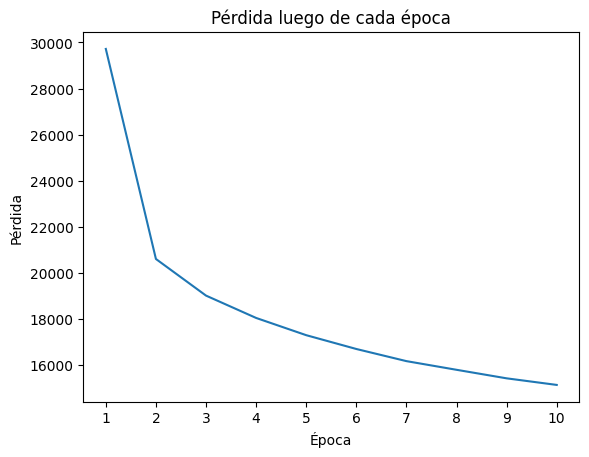

In [ ]:
x = range(1, 11)
y = loss_epoch

fig, ax = plt.subplots()
ax.set_title("Pérdida luego de cada época")
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida')
ax.set_xticks(x)
ax.plot(x, y)

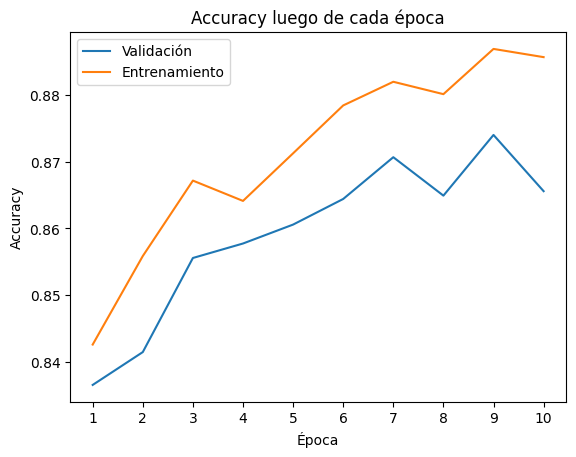

In [ ]:
x = range(1, 11)
y1 = validation_acc_epoch
y2 = train_acc_epoch

fig, ax = plt.subplots()
ax.set_title("Exactitud luego de cada época")
ax.set_xlabel('Época')
ax.set_ylabel('Exactitud')
ax.set_xticks(x)
ax.plot(x, y1, label='Validación')
ax.plot(x, y2, label='Entrenamiento')
ax.legend()


Se obtuvo una exactitud de 88.6% en el conjunto de entrenamiento y 86.6% en el conjunto de validación.

Un detalle interesante es que el valor de la exactitud en el conjunto de entrenamiento tuvo una pequeña caída luego de la última época, a pesar de que la función de pérdida siempre se mantuvo en descenso. Este fenómeno tiene que ver con la forma de cálculo de estas dos medidas, que si bien están muy relacionadas, no son exactamente iguales. Particularmente, la función de pérdida utilizada se verá penalizada de acuerdo a la magnitud de los errores cometidos en la estimación de la probabilidad de las clases. Mientras que la exactitud es una medida que cuantifica la cantidad de errores cometidos en la clasificación, sin importar si se estuvo "cerca" o "lejos" de hacerlo correctamente.

## 3. Experimentación
### 3.1 Arquitecturas Alternativas

Se proponen tres arquitecturas alternativas con el fin de mejorar el desempeño de la red inicial:
- Opción 1: Una capa oculta de 512 unidades con función de activación ReLU.
- Opción 2: Cuatro capas ocultas de 512, 256, 128 y 128 unidades **respectivamente** con función de activación ReLU.
- Opción 3: Dos capas ocultas de 128 y 64 unidades con función de activación tangente hiperbólica.  

Con el fin de disminuir el tiempo de entrenamiento, se decidio utilizar batches de tamaño 32 durante esta etapa. Además se entrenó durante 20 épocas para intentar alcanzar el pico de desempeño en el conjunto de validación.  

Cada modelo se entrena con tasa de aprendizaje 0.001, 0.01 y 0.1.



In [ ]:
def create_model(option):
  if option == 1:
    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 10)
    ).to(device)
  elif option == 2:
    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 10)
    ).to(device)
  elif option == 3:
    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 128),
      nn.Tanh(),
      nn.Linear(128, 64),
      nn.Tanh(),
      nn.Linear(64, 10)
    ).to(device)


In [ ]:
epochs = 20
learning_rates = [0.001, 0.01, 0.1]
loss_fn = nn.CrossEntropyLoss()

loss_epoch, train_acc_epoch, validation_acc_epoch = ({}, {}, {})

for model_option in range(1, 4):
  loss_epoch[model_option], train_acc_epoch[model_option], validation_acc_epoch[model_option] = ({}, {}, {})
  for learning_rate in learning_rates:
    model = create_model(model_option)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    print(f"Model:{model_option} learning_rate:{learning_rate}\n*******************************")
    loss_epoch[model_option][learning_rate], train_acc_epoch[model_option][learning_rate], validation_acc_epoch[model_option][learning_rate] = epoch_loop(epochs, train_dataloader_mini_batch, train_dataloader_batch, validation_dataloader_batch, model, loss_fn, optimizer)


Model:1 learning_rate:0.001
*******************************
Epoch 1
-------------------------------
train_loss=2840.872987508774
train_accuracy=0.6437083333333333
validation_accuracy=0.6459166666666667

Epoch 2
-------------------------------
train_loss=1895.0150454044342
train_accuracy=0.670625
validation_accuracy=0.6715

Epoch 3
-------------------------------
train_loss=1490.2210491895676
train_accuracy=0.692125
validation_accuracy=0.69325

Epoch 4
-------------------------------
train_loss=1304.92030698061
train_accuracy=0.7171041666666667
validation_accuracy=0.7193333333333334

Epoch 5
-------------------------------
train_loss=1196.3931671082973
train_accuracy=0.7398333333333333
validation_accuracy=0.7391666666666666

Epoch 6
-------------------------------
train_loss=1122.0849834382534
train_accuracy=0.7545833333333334
validation_accuracy=0.7515833333333334

Epoch 7
-------------------------------
train_loss=1066.0085190534592
train_accuracy=0.7683125
validation_accuracy=0.76375

Como resultado del entrenamiento se puede observar que los tres modelos logran su mejor rendimiento al entrenarse con una tasa de 0.1.

Se grafica a continuación el valor de exactitud (en el conjunto de validación) para los tres modelos entrenados con la tasa 0.1.

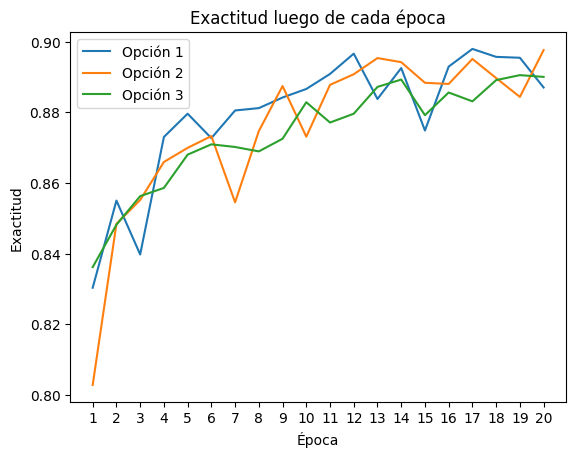

In [ ]:
x = range(1, 21)

fig, ax = plt.subplots()
ax.set_title("Exactitud luego de cada época")
ax.set_xlabel('Época')
ax.set_ylabel('Exactitud')
ax.set_xticks(x)
ax.plot(x, validation_acc_epoch[1][0.1], label='Opción 1')
ax.plot(x, validation_acc_epoch[2][0.1], label='Opción 2')
ax.plot(x, validation_acc_epoch[3][0.1], label='Opción 3')
ax.legend()

Se puede observar que el rendimiento (medido por la exactitud en el conjunto de validación) es bastante similar en los tres modelos, habiendo incluso algunas oscilaciones en las últimas épocas.

A continuación se grafica, para cada modelo entrenado con tasa 0.1, la exactitud en el conjunto de entrenamiento junto a la exactitud en el conjunto de validación, para ver si hay algún indicio de sobreajuste.

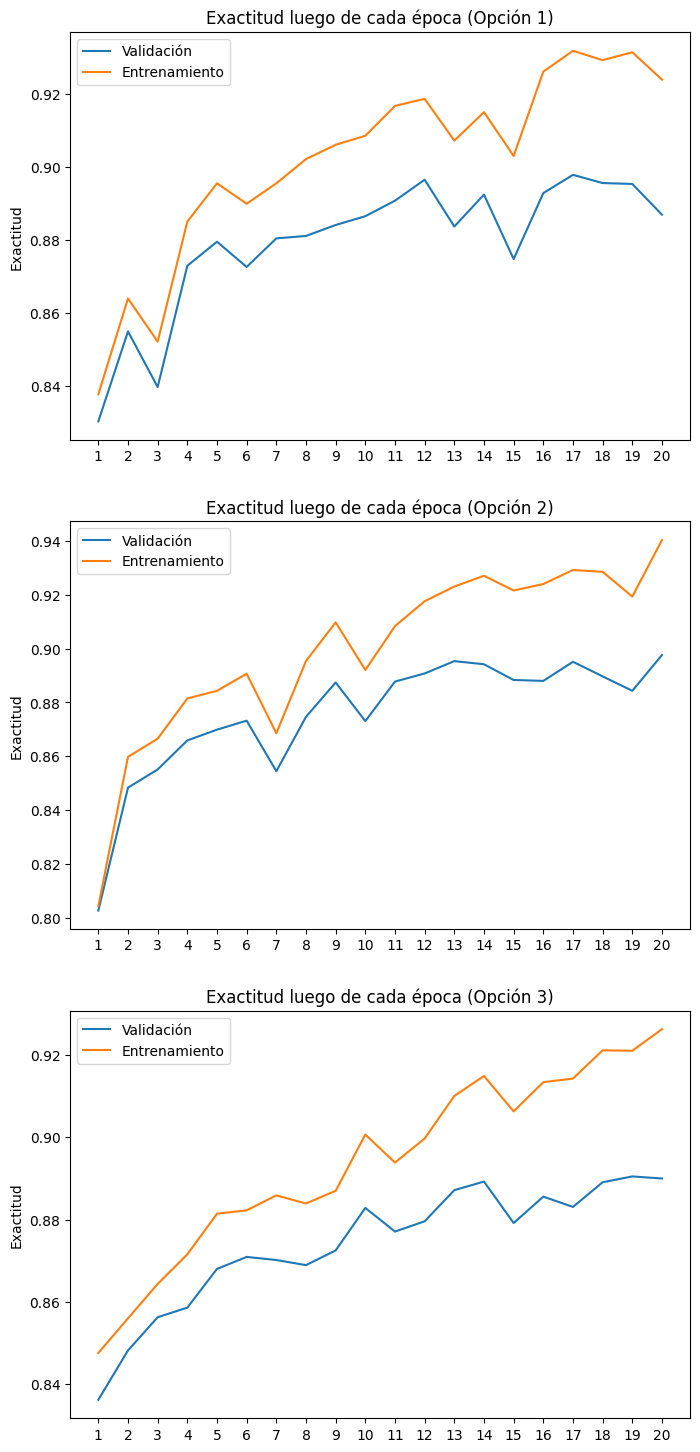

In [ ]:
x = range(1, 21)
fig, ax = plt.subplots(3, figsize=(8, 18))

for model in range(3):
  y1 = validation_acc_epoch[model + 1][0.1]
  y2 = train_acc_epoch[model + 1][0.1]
  ax[model].set_title(f"Exactitud luego de cada época (Opción {model + 1})")
  ax[model].set_ylabel('Exactitud')
  ax[model].set_xticks(x)
  ax[model].plot(x, y1, label='Validación')
  ax[model].plot(x, y2, label='Entrenamiento')
  ax[model].legend()


### 3.1 Regularización mediante dropout

A pesar de no haber un claro "ganador", decidimos seleccionar el modelo correspondiente a la opción 2, entrenado con tasa de aprendizaje 0.1, para continuar la experimentación.

Si bien a partir de las gráficas anteriores no se percibe indicios de sobreajuste en ningún caso, se procede a aplicar regularización sobre este modelo seleccionado utilizando el método dropout con probabilidad 0.2 y 0.5.

In [ ]:
def create_model_dropout(prob):
  return nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Dropout(p=prob),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=prob),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=prob),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(p=prob),
    nn.Linear(128, 10)
  ).to(device)


In [ ]:
epochs = 20
learning_rate = 0.1
probs = [0.2, 0.5]
loss_fn = nn.CrossEntropyLoss()

for prob in probs:
  model = create_model_dropout(prob)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  print(f"Dropout prob:{prob}\n*******************************")
  epoch_loop(epochs, train_dataloader_mini_batch, train_dataloader_batch, validation_dataloader_batch, model, loss_fn, optimizer)


Dropout prob:0.2
*******************************
Epoch 1
-------------------------------
train_loss=1312.3290147334337
train_accuracy=0.8196041666666667
validation_accuracy=0.8123333333333334

Epoch 2
-------------------------------
train_loss=753.9941990226507
train_accuracy=0.8322916666666667
validation_accuracy=0.8254166666666667

Epoch 3
-------------------------------
train_loss=655.3151542693377
train_accuracy=0.8541875
validation_accuracy=0.84625

Epoch 4
-------------------------------
train_loss=609.4145036414266
train_accuracy=0.8669791666666666
validation_accuracy=0.8559166666666667

Epoch 5
-------------------------------
train_loss=569.2410518974066
train_accuracy=0.8812083333333334
validation_accuracy=0.8663333333333333

Epoch 6
-------------------------------
train_loss=544.8401857595891
train_accuracy=0.89
validation_accuracy=0.8758333333333334

Epoch 7
-------------------------------
train_loss=523.6843554787338
train_accuracy=0.890625
validation_accuracy=0.8745

Epoch

### 3.2 Regularización L2

Por otra parte, se aplica regularización L2 con lambda 0.001 y 0.01.

In [ ]:
epochs = 20
learning_rate = 0.1
lambdas = [0.001, 0.01]
loss_fn = nn.CrossEntropyLoss()
best_model = 2

for lambda_L2 in lambdas:
  model = create_model(best_model)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_L2)

  print(f"Lambda:{lambda_L2}\n*******************************")

  epoch_loop(epochs, train_dataloader_mini_batch, train_dataloader_batch, validation_dataloader_batch, model, loss_fn, optimizer)


Lambda:0.001
*******************************
Epoch 1
-------------------------------
train_loss=1241.2024648338556
train_accuracy=0.8268333333333333
validation_accuracy=0.8158333333333333

Epoch 2
-------------------------------
train_loss=699.113608032465
train_accuracy=0.8581666666666666
validation_accuracy=0.8459166666666667

Epoch 3
-------------------------------
train_loss=613.0523790866137
train_accuracy=0.8624583333333333
validation_accuracy=0.85075

Epoch 4
-------------------------------
train_loss=579.3823337927461
train_accuracy=0.8498541666666667
validation_accuracy=0.8384166666666667

Epoch 5
-------------------------------
train_loss=550.8524134010077
train_accuracy=0.8543541666666666
validation_accuracy=0.8441666666666666

Epoch 6
-------------------------------
train_loss=532.6959078684449
train_accuracy=0.8349375
validation_accuracy=0.8258333333333333

Epoch 7
-------------------------------
train_loss=514.8766695484519
train_accuracy=0.8812916666666667
validation_acc

## 4. Resultados

Exactitud sobre el conjunto de validación de las diferentes redes construidas.

- Red inicial: 86.6%

- Redes alternativas:

<table>
  <tr>
    <th> tasa/modelo </th>
    <th>Opción 1</th>
    <th>Opción 2</th>
    <th>Opción 3</th>
  </tr>
  <tr>
    <th>0.001</th>
    <td>81.8%</td>
    <td>76.2%</td>
    <td>80.4%</td>
  </tr>    
  <tr>
    <th>0.01</th>
    <td>87.4%</td>
    <td>88.5%</td>
    <td>87.1%</td>
  </tr>
  <tr>
    <th>0.1</th>
    <td>88.7%</td>
    <td><b>89.8%</b></td>
    <td>89.0%</td>
  </tr>
  <caption>Tabla 1 - Exactitud de cada red alternativa</caption>
</table>

- Red de opción 2 con regularización

<table>
  <tr>
    <th>Dropout 0.2</th>
    <th>Dropout 0.5</th>
    <th>L2 0.001</th>
    <th>L2 0.01</th>
  </tr>
  <tr>
    <td>88.5%</th>
    <td>87.8%</td>
    <td>88.5%</td>
    <td>79.3%</td>
  </tr>    
  <caption>Tabla 2 - Exactitud al aplicar regularización</caption>
</table>

Se puede ver que a partir de redes más complejas que la inicial, se obtuvo mejores rendimientos, aunque el rendimiento de la red inicial ya era bueno y no se mejoró de gran manera.  
Por otra parte, aplicar regularización no mejoró los resultados del mejor modelo obtenido previamente, lo que deja claro que no había problema de sobreajuste desde un principio. Algo que apoya esta observación es que cuanto menor es la regularización aplicada, mejor es el rendimiento del modelo.  
El hecho de que no haya sobreajuste puede deberse a varios factores, uno es la buena cantidad de datos de entrenamiento, que hace que sea dificil aproximarlos por una función de gran complejidad. Otro es el hecho de que si bien las arquitecturas alternativas son más complejas que la inicial, quizás la cantidad de paramétros sigue siendo insuficiente para obtener funciones que se ajusten aún mejor a los datos de entrenamiento, llegando a un nivel de sobreajuste. También puede deberse simplemente a que la cantidad de épocas utilizadas para el entrenamiento no fue suficiente.  
Cabe mencionar que se optó por la opción 2 de los modelos sin regularización porque fue el que tuvo mayor exactitud, pero los tres modelos tuvieron un rendimiento similar, y la oscilación en las últimas épocas muestra que si se hubiera detenido el entrenamiento antes, o se hubiera continuado aún más, el mejor modelo podría haber sido alguno de los otros.


## 4.1 Resultados en conjunto de evaluación

Se procede a entrenar nuevamente el modelo con la arquitectura de la opción 2, tasa de aprendizaje 0.1 y sin regularización sobre el conjunto de entrenamiento completo (incluyendo validación).
Posteriormente se prueba sobre el conjunto de evaluación, que no se ha utilizado aún en ninguno de los pasos anteriores.

In [ ]:
batch_size = 32
all_train_dataloader_mini_batch = DataLoader(all_train_data, batch_size=batch_size, shuffle=True)
all_train_dataloader_batch = DataLoader(all_train_data, batch_size=len(all_train_data), shuffle=False)
test_dataloader_batch = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

epochs = 20
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
best_model = 2
model = create_model(best_model)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")

  train_loss = train_loop(all_train_dataloader_mini_batch, model, loss_fn, optimizer)
  print(f"{train_loss=}")

  train_accuracy = test_loop(all_train_dataloader_batch, model)
  print(f"{train_accuracy=}")

  test_accuracy = test_loop(test_dataloader_batch, model)
  print(f"{test_accuracy=}\n")

Epoch 1
-------------------------------
train_loss=1379.211264282465
train_accuracy=0.8441666666666666
test_accuracy=0.8322

Epoch 2
-------------------------------
train_loss=788.514505520463
train_accuracy=0.84435
test_accuracy=0.8311

Epoch 3
-------------------------------
train_loss=695.91157925874
train_accuracy=0.8799166666666667
test_accuracy=0.8598

Epoch 4
-------------------------------
train_loss=637.7704610265791
train_accuracy=0.8812166666666666
test_accuracy=0.8638

Epoch 5
-------------------------------
train_loss=595.3541871979833
train_accuracy=0.89765
test_accuracy=0.8724

Epoch 6
-------------------------------
train_loss=563.9943543225527
train_accuracy=0.8937666666666667
test_accuracy=0.8732

Epoch 7
-------------------------------
train_loss=536.2644807994366
train_accuracy=0.9046833333333333
test_accuracy=0.8766

Epoch 8
-------------------------------
train_loss=513.207669198513
train_accuracy=0.9054833333333333
test_accuracy=0.8773

Epoch 9
------------------

In [ ]:
y_true = []
y_pred = []
y_probab = torch.empty(0, 10).to(device)

model.eval()

with torch.no_grad():
  for X, y in test_dataloader_batch:
    X, y = X.to(device), y.to(device)
    logits = model(X)
    pred_probab = nn.Softmax(dim=1)(logits)
    pred_class = pred_probab.argmax(dim=1)
    y_pred.extend(pred_class.tolist())
    y_true.extend(y.tolist())
    y_probab = torch.cat((y_probab, pred_probab), dim=0)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Calcular accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_report(y_true, y_pred))


Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.83      0.82      1000
           3       0.89      0.92      0.90      1000
           4       0.84      0.79      0.81      1000
           5       0.99      0.96      0.98      1000
           6       0.74      0.71      0.73      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Métricas:
- En general el modelo tiene un buen rendimiento con una exactitud del 90% en el conjunto de evaluación.
- Las categorías en las que mejor se desempeña son la 1, 5, 7, 8 y 9. Esto se aprecia en los valores de precisión, recall y f1-score, que son todos muy cercanos a 1.
- Las categorías 0, 2, 3, 4 y 6 podrían ser áreas a mejorar si se quiere alcanzar un mejor rendimiento del modelo. En particular, la clase 6 que es la que obtuvo peores resultados (corresponde a la clase "shirt").
- Todos los valores de precisión y recall están balanceados para cada clase, resultando en un buen valor de f1-score, por lo que se concluye que no hay un sesgo hacia alguna clase en particular. El hecho de que el conjunto de datos está perfectamente balanceado favorece esto.
- Al comparar la exactitud obtenida con las reportadas en el sitio del conjunto de datos, se puede ver que si bien son mayores en casi todos los casos, la diferencia no es muy grande. Esto es sorprendente al tratarse de un modelo más simple que la gran mayoría, que aplican capas de convolución y redes con arquitecturas mucho más complejas, creadas por investigadores reconocidos. Por otra parte, se obtuvo un mejor desempeño que el nivel humano, que de acuerdo el sitio es de 83.5%.

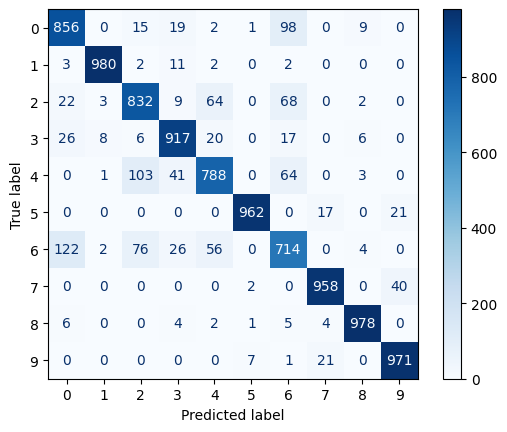

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')

### Matriz de confusión:
- En la matriz se puede ver que en general los valores de la diagonal son altos en todas las clases, lo que denota un buen desempeño del modelo.
- Se percibe cierta confusión en algunas clases, a partir de celdas (fuera de la diagonal) con valores inusualmente altos. Ejemplos de esto son: la clase 0 que se confunde con la 6, la 2 que se confunde con la 4 y la 6, la 4 que se confunde con la 2 y la 6, y la 6 que se confunde con la 0, la 2, y la 4.
- El hecho de que la clase 6 se confunda con varias clases reafirma lo visto en las métricas anteriores, que es la clase con peor desempeño.
- Los valores más altos de la diagonal están en las clases 1, 3, 5, 7, 8 y 9. Esto también confirma lo visto previamente en las métricas, que son las clases con mejor desempeño.

## 4.2 Instancias más dificiles

Se muestran a continuación las 10 instancias del conjunto de evaluación que resultaron más "dificiles" de clasificar para el modelo. La medida utilizada fue la entropía.  
Además se muestra para cada imagen la clase real y la predicha por el modelo.

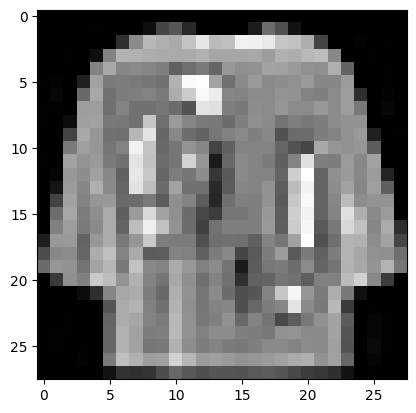

     Class: T-shirt/top    Predicted: Pullover




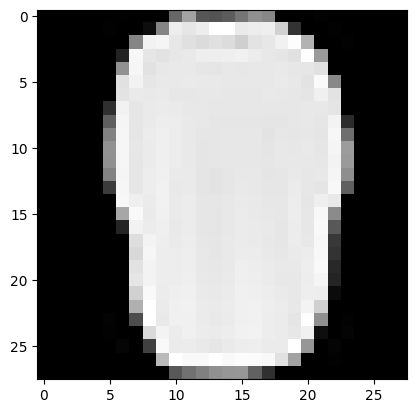

     Class: T-shirt/top    Predicted: Dress




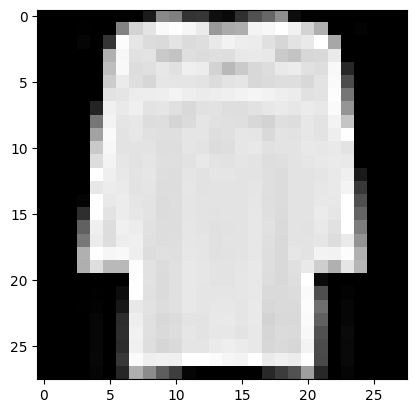

     Class: Shirt    Predicted: Pullover




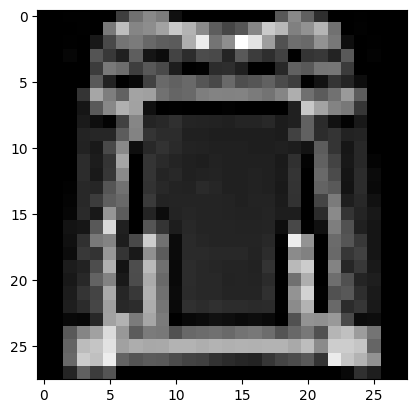

     Class: Pullover    Predicted: Pullover




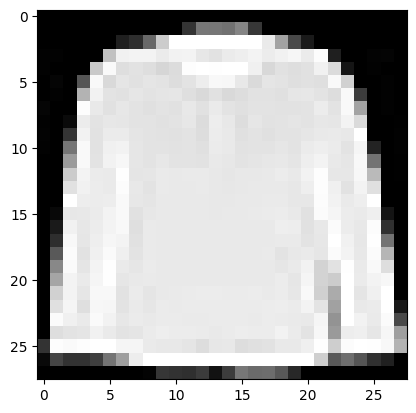

     Class: Coat    Predicted: Pullover




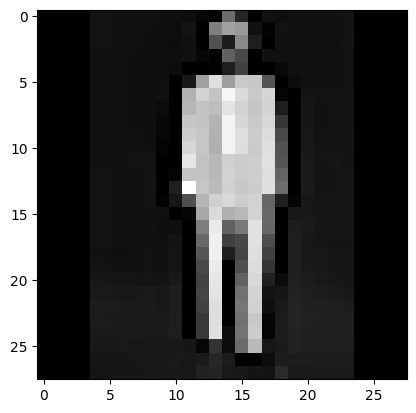

     Class: Trouser    Predicted: Pullover




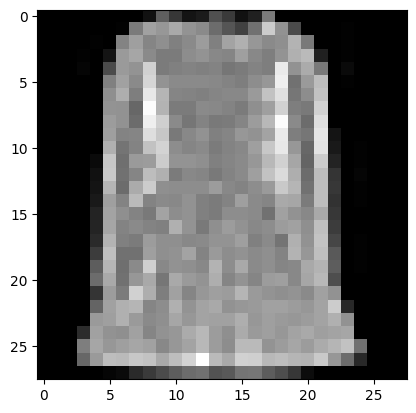

     Class: Dress    Predicted: Bag




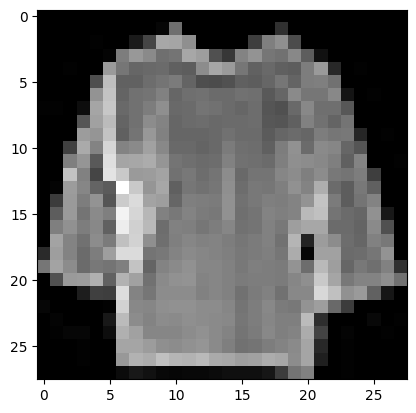

     Class: Shirt    Predicted: Pullover




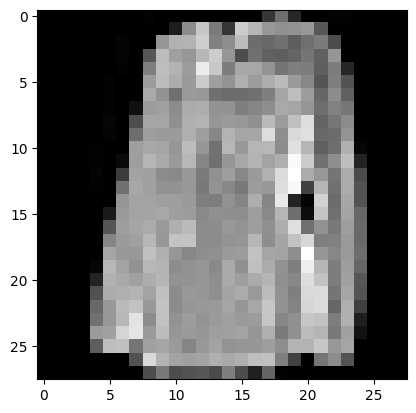

     Class: Shirt    Predicted: Bag




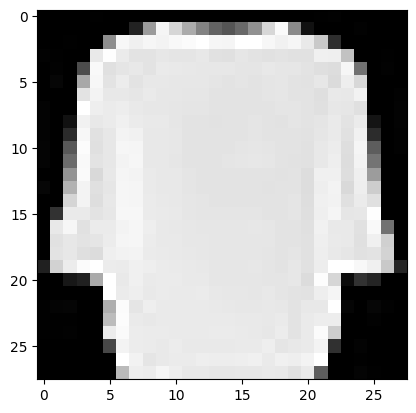

     Class: T-shirt/top    Predicted: Pullover




In [ ]:
entropies = -torch.sum(y_probab * torch.log2(y_probab), axis=1)
top_values, top_indices = entropies.topk(10)

classes = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

for i in top_indices:
  i = i.item()
  # Display image and label.
  features, label = test_data[i]
  img = features[0].squeeze()
  plt.imshow(img, cmap="gray")
  plt.show()
  print(f"     Class: {classes[label]}    Predicted: {classes[y_pred[i]]}\n\n")

En algunos casos, por más que la clasificación haya sido dificil, el modelo lo hizo correctamente.  
Por otra parte, varias de las imágenes más dificiles son de la clase shirt, esto es coherente con lo visto en la matriz de confusión, en donde se precibe bastante dispersión de las predicciones en esta clase.  
Cabe destacar que muchas de estas imágenes "dificiles" resultarían dificiles de clasificar incluso para un ser humano, debido a la baja resolución y la poca variación de color.

## 5. Conclusión

Se experimentó con distintas arquitecturas de Redes Neuronales para resolver un problema de clasificación multiclase sobre un dataset conocido. Se comenzó por arquitecturas más simples, para luego ir aumentando la complejidad, pero siempre dentro del tipo FeedForward.
La capacidad de computo disponible impuso ciertas restricciones sobre el entrenamiento, quizás por ese motivo no se llegó a observar un fenómeno claro de sobreajuste en ninguno de los modelos.

Se puede concluir que se obtuvo un buen desempeño en el modelo final construido, que no dista mucho de los valores publicados en el sitio. Algunos caminos para intentar mejorar este desempeño podrían ser aplicar técnicas que ataquen específicamente el problema de las clases con peor rendimiento, o directamente utilizar tipos de arquitecturas de redes con mayor complejidad.